In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import bioframe

import pyBigWig

In [2]:
def jets_vs_ChIP(jets_bed4,Peaks_bed3,BW,jet_flank):
    mids = (jets_bed4['end']+jets_bed4['start'])/2
    
    vals = []
    for i in range(len(jets_bed4)):
        a = 'chr'+jets_bed4['chrom'][i]
        b = mids[i]-jet_flank
        if b<0:
            b=0
        c = mids[i]+jet_flank
        if c>BW.chroms(a):
            c=a
        v = BW.stats(a,int(b),int(c),type='mean',nBins=1)
        vals.append(v)
#    print(len(jets_bed4),len(vals))
    d = {'val': np.hstack(vals)}
    df = pd.concat([jets_bed4, pd.DataFrame(d)], axis=1)
    
    #### add column quantiling jet strength ###
    df['q_name'] = 'q'
    q1 = df['name']<=np.quantile(df['name'], 0.25)
    q2 = np.logical_and(df['name']>np.quantile(df['name'], 0.25),df['name']<=np.quantile(df['name'], 0.5))
    q3 = np.logical_and(df['name']>np.quantile(df['name'], 0.5),df['name']<=np.quantile(df['name'], 0.75))
    q4 = df['name']>np.quantile(df['name'], 0.75)
    print(len(df),q1.sum(),q2.sum(),q3.sum(),q4.sum())
    
    df.loc[q1, ['q_name']] = 'q1'
    df.loc[q2, ['q_name']] = 'q2'
    df.loc[q3, ['q_name']] = 'q3'
    df.loc[q4, ['q_name']] = 'q4'
    
    ################## npeaks per jet-range #################
    df_range = {'chrom': 'chr'+df['chrom'], 'start': df['start']-jet_flank, 'end': df['end']+jet_flank}
    df_r = pd.DataFrame(data=df_range)
    
    
    nPeaks = bioframe.count_overlaps(df_r,Peaks_bed3)['count']
    out = pd.concat([df, pd.DataFrame(nPeaks)], axis=1)
    return(out)

In [3]:

# jets
jets_annot = bioframe.read_table('/home/kimj50/cohesin_paper/jets_call/jetcall_v5_w30kb.bed',schema='bed4')

# nipbl
bw_nipbl = pyBigWig.open("/home/kimj50/cohesin_paper/other_chips_pqn_pol2/avg/PQN85_Q4481_CA1200_1hrauxin_HW01_JK191_L3_inputsubt_avgFIX.bw")
nipbl_p = bioframe.read_table('/home/kimj50/cohesin_paper/other_chips_pqn_pol2/MACSoutput_nipbl_subset/PQN85_Q4481_CA1200_1hrauxin_L3_avg_HW01_JK191_chip_peaks.bed',schema='bed12').iloc[:,range(3)]

dat = jets_vs_ChIP(jets_annot,nipbl_p,bw_nipbl,3000)


287 72 72 71 72


0.6
0.61


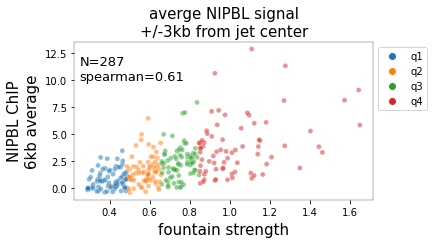

In [4]:
f, axs = plt.subplots(
    figsize=(6, 3.5),
    nrows=1,
    ncols=1,
    sharex=True,
    sharey='row'
)
bigFont = 15

Pcorr = dat['name'].corr(dat['val'],method='pearson')
Scorr = dat['name'].corr(dat['val'],method='spearman')
print(round(Pcorr, 2))
print(round(Scorr, 2))
sns.scatterplot(ax=axs,data=dat, x="name", y="val",hue='q_name',
                hue_order=('q1','q2','q3','q4'),alpha=0.5,s=25)
axs.set_title("averge NIPBL signal\n+/-3kb from jet center",size=bigFont)

plt.text(0.25, 10., "N="+str(len(dat))+"\nspearman="+str(round(Scorr,2)),fontsize=bigFont-2)


axs.set_ylabel("NIPBL ChIP\n6kb average",rotation=90,fontsize=bigFont, labelpad=5)
axs.set_xlabel("fountain strength",fontsize=bigFont, labelpad=5)
axs.legend(loc = 2, bbox_to_anchor = (1,1))

for axis in ['top', 'bottom', 'left', 'right']:
    axs.spines[axis].set_linewidth(0.3)
plt.tight_layout()

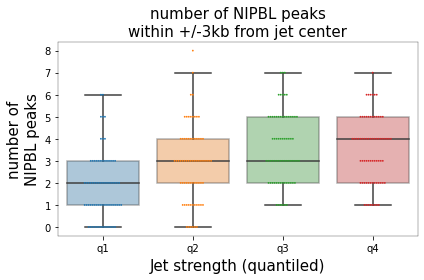

In [5]:
f, axs = plt.subplots(
    figsize=(6, 4),
    nrows=1,
    ncols=1,
    sharex=True,
    sharey='row'
)
bigFont = 15
sns.swarmplot(ax=axs,data=dat, x="q_name", y="count",order=('q1','q2','q3','q4'),alpha=1,s=1.8)
sns.boxplot(ax=axs,data=dat, x="q_name", y="count", order=('q1','q2','q3','q4'),boxprops={'alpha': 0.4},showfliers = False)


axs.set_title("number of NIPBL peaks\nwithin +/-3kb from jet center",size=bigFont)
axs.set_ylabel("number of\nNIPBL peaks",rotation=90,fontsize=bigFont, labelpad=5)
axs.set_xlabel("Jet strength (quantiled)",fontsize=bigFont, labelpad=5)


for axis in ['top', 'bottom', 'left', 'right']:
    axs.spines[axis].set_linewidth(0.3)
plt.tight_layout()